In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from astropy.table import Table
t = Table.read('../ophiuchus.vot', format='votable')

print("Finished reading Table. Read ",len(t['__Gmag_'])," sources")

Finished reading Table. Read  503325  sources


In [3]:
print("The astropy reader loads the data into the following variable names:")
print(t.colnames)

The astropy reader loads the data into the following variable names:
['RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var']


In [5]:
RA = t['RA_ICRS']
DE = t['DE_ICRS']
plx = t['Plx']
Gmag = t['__Gmag_']
num = len(RA)


In [6]:
X1 = np.zeros(num)
Y1 = np.zeros(num)
for i in range(0,num):
    X1[i] = RA[i]
    Y1[i] = DE[i]
X = np.column_stack((X1,Y1))
print(len(X))

503325


In [9]:
#create subset of stars with magnitudes < 17
Gstars = np.array([])
Gstars_indices = np.array([])
for i in range(len(Gmag)):
    if (Gmag[i] <= 17):
        Gstars = np.append(Gstars, Gmag[i])
        Gstars_indices = np.append(Gstars_indices, i)
print(len(Gstars))

GRA = np.array([])
GDE = np.array([])
for i in Gstars_indices:
    j = int(i)
    GRA = np.append(GRA, RA[j])
    GDE = np.append(GDE, DE[j])
    
#array of coordiantes for the stars
num = len(Gstars)
X2 = np.zeros(num)
Y2 = np.zeros(num)
for i in range(0,num):
    X2[i] = GRA[i]
    Y2[i] = GDE[i]
X2 = np.column_stack((X2,Y2))
print(len(X2))

46759
46759


(array([  2.00000000e+00,   1.50000000e+01,   6.80000000e+01,
          4.18000000e+02,   2.46800000e+03,   1.06520000e+04,
          4.13680000e+04,   1.51763000e+05,   2.95928000e+05,
          6.43000000e+02]),
 array([  4.28800011,   6.13630009,   7.98460007,   9.83290005,
         11.68120003,  13.52950001,  15.37779999,  17.22609997,
         19.07439995,  20.92269993,  22.77099991]),
 <a list of 10 Patch objects>)

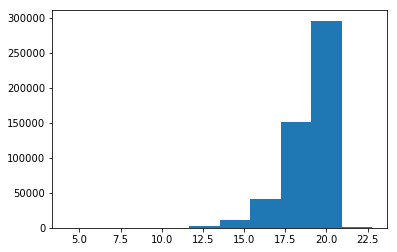

In [5]:
plt.hist(Gmag)

In [8]:
#compare stelllar densities in different regions
stars1 = 0
stars2 = 0

for i in range(len(RA)):
    if ( RA[i] > 249 and RA[i] < 249.5 and DE[i] > -23 and DE[i] < -22.5):
        stars1 = stars1 + 1
    if (RA[i] > 246.5 and RA[i] < 247 and DE[i] > -24.75 and DE[i] < -24.25):
        stars2 = stars2 + 1
density1 = stars1/(0.5*0.5)
density2 = stars2/(0.5*0.5)

print(density1)
print(density2)        

31000.0
392.0


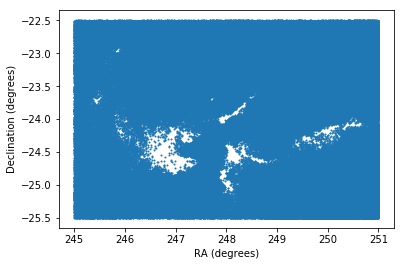

In [6]:
plt.scatter(RA,DE, s = 1)
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

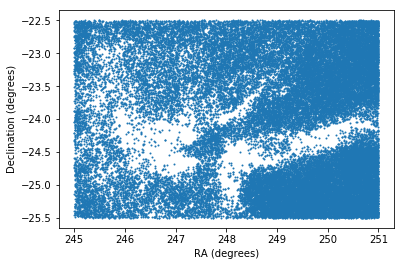

In [11]:
plt.scatter(GRA,GDE, s = 1)
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

In [7]:
#ranges of coordinates and density of stars
RAmin = min(RA)
RAmax = max(RA)
DEmin = min(DE)
DEmax = max(DE)
RA_range = RAmax - RAmin
DE_range = DEmax - DEmin
area = RA_range*DE_range
num = len(RA)
density = num/area
print(RA_range)
print(DE_range)
print(area)
print(num)
print(density)

5.9999703714
2.9999811586
17.9997980664
503325
27962.8137018


In [8]:
#create mapping function
def distance_map(data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,image, scatter, contour):
    from scipy.spatial import KDTree

    #use KD tree to find distances to nearest neighbor stars
    tree = KDTree(data)
    
    diffRA = (RAmax - RAmin)
    diffDE = (DEmax - DEmin)
    
    pixel_count2 = pixel_count
    
    if (diffRA < diffDE):
        dDE = diffDE/pixel_count2
        pixel_count = int(diffRA/dDE)
        dRA = diffRA/pixel_count
    if (diffRA > diffDE):
        dRA = diffRA/pixel_count
        pixel_count2 = int(diffDE/dRA)
        dDE = diffDE/pixel_count2
    if (diffRA == diffDE):
        dRA = diffRA/pixel_count
        dDE = diffDE/pixel_count
        
    #create array of coordinates for image background
    for i in range(0,pixel_count):
        for j in range(0,pixel_count2):
            if (i==0 and j == 0):
                array4 = np.array([RAmin,DEmin])
            else:
                array3 = [RAmin+i*dRA,DEmin+j*dDE]
                array4 = np.vstack((array4,array3))

    #find nearest neighbor distances to background points
    image = tree.query(array4,k=neighbor+1)

    #change array of background points so it is pixel_count x pixel_count2
    dist2 = image[0][:,neighbor-1]
    dist2 = np.resize(dist2,(pixel_count,pixel_count2))
    dist2 = np.rot90(dist2, k=1, axes=(1,0))
    dist2 = np.fliplr(dist2)

    #display map   
    plt.imshow(dist2, origin='lower',extent=[RAmin,RAmax,DEmin,DEmax])
    plt.show()
    
    #contour plot
    if (contour == True):
        ct = plt.contourf(dist2, cmap='tab10',extent=[RAmin,RAmax,DEmin,DEmax])
        plt.colorbar()
        plt.show()
    #scatter plot
    if (scatter == True):
        plt.scatter(data[:,0],data[:,1],s = 1,c = 'k')
        plt.show()
    return dist2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
from scipy.spatial import distance
from scipy import spatial
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from matplotlib.patches import Circle, Wedge, Polygon

In [27]:
def StarSelection(distArray,data,RA,DEC,L):
    
    ## SPECIFY RA AND DEC RANGES
    RArange = RA
    DECrange = DEC
    
    fig, ax = plt.subplots()
    ax.set_facecolor('black')
    xgrid = np.linspace(np.min(data[:,0]),np.max(data[:,0]),int(np.sqrt(np.size(distArray))))
    ygrid = np.linspace(np.min(data[:,1]),np.max(data[:,1]),int(np.sqrt(np.size(distArray))))
    X, Y = np.meshgrid(xgrid,ygrid)
    X = np.array(X)
    Y = np.array(Y)
    cs = plt.contour(X,Y,distArray,5,alpha=1.0)
    plt.colorbar()
    plt.axvline(x=RArange,linestyle='--',color='y',alpha=0.6)
    plt.axhline(y=DECrange,linestyle='--',color='y',alpha=0.6)
    plt.xlim(np.min(X),np.max(X))
    plt.ylim(np.min(Y),np.max(Y))
    plt.gca().invert_xaxis()

    insideStars = []
    starCount = 0
    inside = []
    finalPoly = []
    for i in range(len(cs.collections[L].get_paths())):
        p = cs.collections[L].get_paths()[i]
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        if(RArange >= np.min(x) and RArange <= np.max(x) and DECrange >= np.min(y) and DECrange <= np.max(y)):
            polygon = v
            path = mpltPath.Path(polygon,closed=True)
            inside = path.contains_points(redData)
            finalPoly = [x,y]
            
    finalPoly = np.transpose(np.array(finalPoly))
    print(finalPoly[0])
    inside_higher = []        
    for j in range(len(cs.collections[L+1].get_paths())):
                p = cs.collections[L+1].get_paths()[j]
                v = p.vertices
                x = v[:,0]
                y = v[:,1]
                if(np.min(x)>=np.min(finalPoly[:,0]) and np.max(x)<=np.max(finalPoly[:,0]) and np.min(y)>=np.min(finalPoly[:,1]) and np.max(y)<=np.max(finalPoly[:,1])):
                    polygon = v
                    path2 = mpltPath.Path(polygon,closed=False)
                    inside_higher = path2.contains_points(redData)
                    
                    for x in range(len(inside_higher)):
                        if((inside_higher[x]) == True):
                            inside[x] = False 
                    
    for i in range(len(inside)):
        if((inside[i]) == True):
            starCount = starCount + 1
            insideStars.append(redData[i])
    insideStars = np.array(insideStars)

    plt.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',alpha=0.6,marker='*')
    if(len(insideStars) > 0):
        plt.scatter(insideStars[:,0],insideStars[:,1],s=2.0,c='r')
        print('Total Stars within contour: ',starCount,'\n\n')
        plt.show()
    else:
        print('No stars located within selected contour')
        plt.show()

TypeError: Shape of x does not match that of z: found (176, 176) instead of (124, 250).

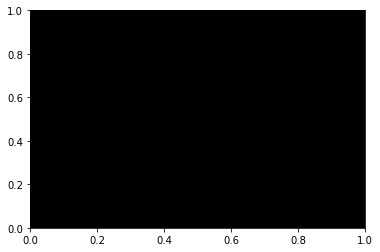

In [28]:
StarSelection(distances,X,246,-24,1)

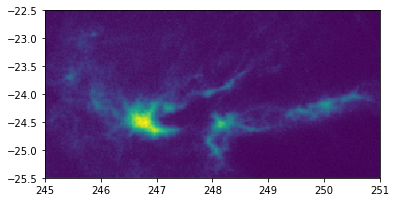

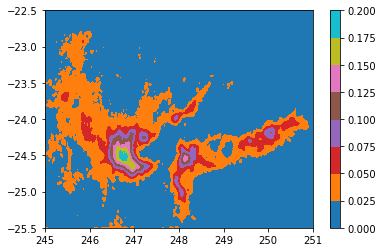

Elapsed time is: 55.73945531750746


In [12]:
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 250
image = False
scatter = False
contour = True
neighbor = 20

distances = distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,image, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

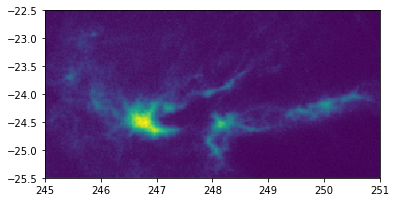

Elapsed time is: 63.334371053406414


In [11]:
import timeit
start_time = timeit.default_timer()
    
#range of coordinates
pixel_count = 250
image = False
scatter = False
contour = False
neighbor = 20

distances = distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,image, scatter, contour)
num = timeit.default_timer() - start_time
print('Elapsed time is: ' + str(num))

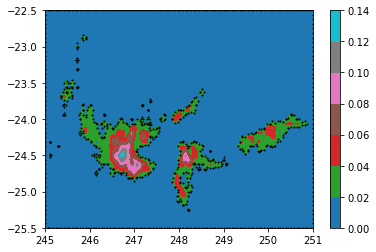

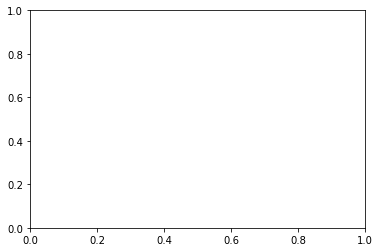

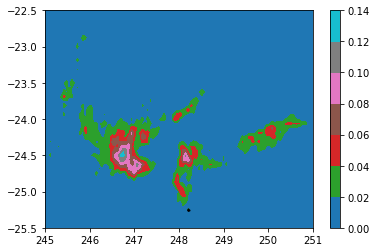

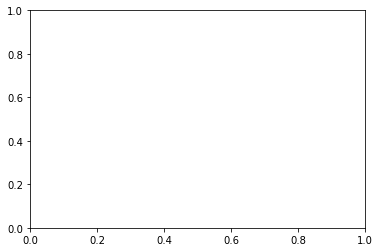

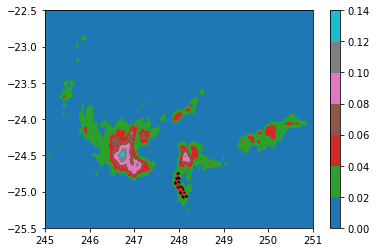

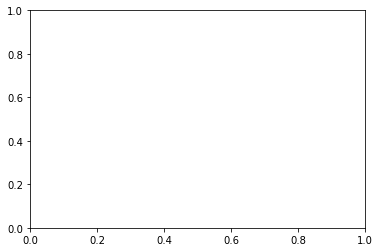

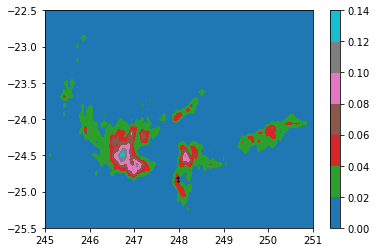

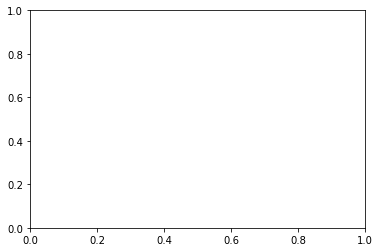

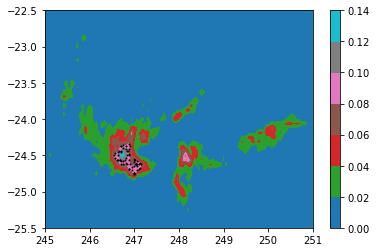

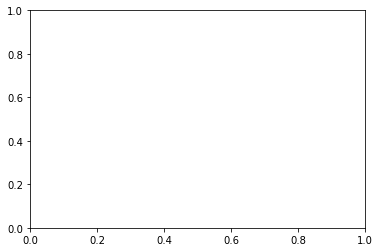

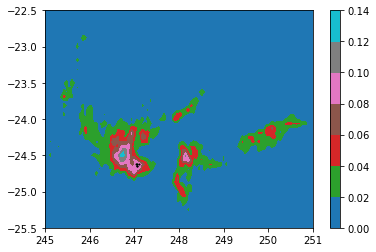

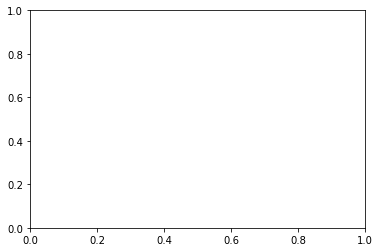

In [67]:
#Find stars between contours

def star_contours(dist,RAmin,RAmax,DEmin,DEmax,L):
    from matplotlib.patches import Circle, Wedge, Polygon
    from matplotlib.collections import PatchCollection
    
    ct = plt.contourf(dist, cmap='tab10',extent=[RAmin,RAmax,DEmin,DEmax])
    plt.xlim(RAmin,RAmax)
    plt.ylim(DEmin,DEmax)
    plt.colorbar()
    
    b = ct.collections[L].get_paths()[0]
    v = b.vertices
    x = v[:,0]
    y = v[:,1]
    plt.scatter(x,y,s=1,c = 'k')
    
    fig, ax = plt.subplots()
    polygon = Polygon(v, True)
    patches = []
    p = PatchCollection(patches, alpha=0.4)
    colors = 100*np.random.rand(len(patches))
    p.set_array((np.array(colors)))
    ax.add_collection(p)
    patches.append(polygon)
    
    plt.show()
    return

A = RAmin
B = RAmax
C = DEmin
D = DEmax

star_contours(distances,A,B,C,D,0)
star_contours(distances,A,B,C,D,1)
star_contours(distances,A,B,C,D,2)
star_contours(distances,A,B,C,D,3)
star_contours(distances,A,B,C,D,4)
star_contours(distances,A,B,C,D,5)

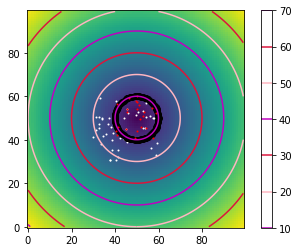

23


In [113]:
#find number of points between contours (test set)

points = np.random.rand(50,2)*30+30
import math
for i in range(0,100):
        for j in range(0,100):
            if (i==0 and j == 0):
                points2 = np.array([0,0])
            else:
                array = [i,j]
                points2 = np.vstack((points2,array))
z= np.zeros((100,100))
for x in range(0,100):
    for y in range(0,100):
        val = math.pow(x-50,2) +math.pow(y-50,2)
        z[x,y] = math.sqrt(val)
plt.imshow(z,origin = 'lower')
plt.scatter(points[:,0],points[:,1],s=1,c='w')
a = plt.contour(z, colors = ['m','lightpink','crimson'])
b = a.collections[0].get_paths()[0]
plt.colorbar()
v = b.vertices
x = v[:,0]
y = v[:,1]
plt.scatter(x,y,c = 'k')

count = 0
for i in range(len(points)):
    if ((points[i,0] < max(x)) and (points[i,0] > min(x)) and (points[i,1] < max(y)) and (points[i,1] > min(y))):
        plt.scatter(points[i,1],points[i,0],s=1,c = 'r')
        count = count+1
plt.show()
print(count)


In [41]:
#Find number of stars with parallaxes
parallaxes = np.array([])
plx_indices = np.array([])
for i in range(len(plx)):
    if (plx[i] > 0):
        parallaxes = np.append(parallaxes, plx[i])
        plx_indices = np.append(plx_indices, i)
print(len(parallaxes))
distances = 1000/parallaxes

#find index of outlier
for i in range(len(distances)):
    if (distances[i] > 40000):
        print(i)
        print(distances[i])
        
#remove outlier
parallaxes  = np.delete(parallaxes, 61)
plx_indices = np.delete(plx_indices, 61)
distances = np.delete(distances, 61)
print(len(parallaxes))

240
61
50000.0011176
239


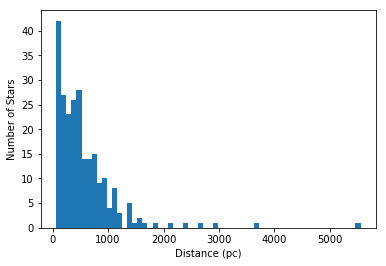

In [39]:
#Create subset of stars of known distances 
RA_dist = np.array([])
DE_dist = np.array([])
for i in plx_indices:
    j = int(i)
    RA_dist = np.append(RA_dist, RA[j])
    DE_dist = np.append(DE_dist, DE[j])
    
plt.hist(distances, bins = 60)
plt.xlabel('Distance (pc)')
plt.ylabel('Number of Stars')
plt.show()

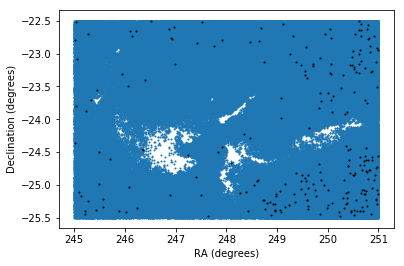

In [38]:
plt.scatter(RA,DE, s = 1)
plt.scatter(RA_dist, DE_dist, s=1, c = 'k')
plt.xlabel('RA (degrees)')
plt.ylabel('Declination (degrees)')
plt.show()

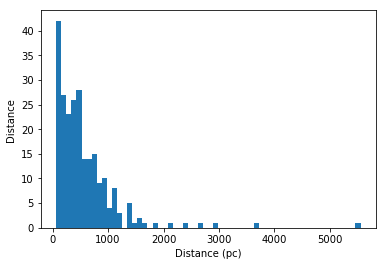

In [40]:
plt.hist(distances, bins = 60)
plt.xlabel('Distance (pc)')
plt.ylabel('Distance ')

In [42]:
count = 0
for i in range(len(distances)):
    if (distances[i] <= 140):
        print(distances[i])
        count = count +1
print(count)

84.817642344
112.233447489
90.4159097703
132.45032778
98.8142303664
135.501352912
126.903551456
80.7102479653
138.31258608
129.366105761
84.745761342
135.317999738
83.963057331
81.1030013129
80.515297412
97.3709791068
103.092785532
87.9507484666
107.296140852
122.399019665
64.3086808832
71.5307605683
90.6618335639
62.3830291432
137.741042489
79.8084613975
97.3709791068
101.832997055
136.425649442
105.042011756
139.275769347
93.4579455912
130.718952619
135.869562753
84.1750833642
84.745761342
36


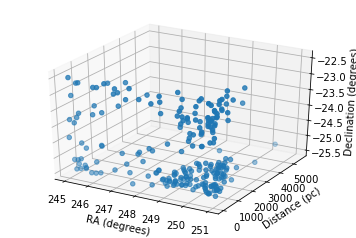

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(RA_dist,distances,DE_dist)
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Distance (pc)')
ax.set_zlabel('Declination (degrees)')

plt.show()

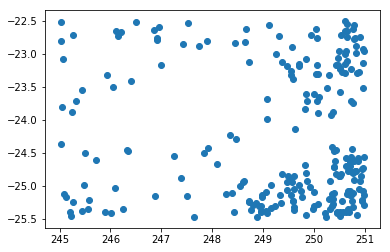

In [45]:
plt.scatter(RA_dist, DE_dist)
plt.show()

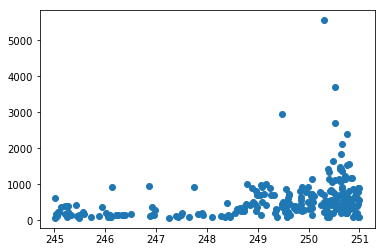

In [46]:
plt.scatter(RA_dist, distances)
plt.show()

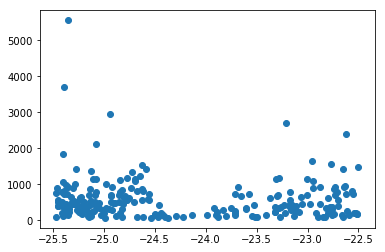

In [47]:
plt.scatter(DE_dist, distances)
plt.show()